In [1]:
import pyLDAvis.gensim
#from pipeline import TopicModeller
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
from gensim import corpora
#pyLDAvis.enable_notebook()
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel, LdaMulticore
#import tm_functions
import matplotlib.pyplot as plt
%matplotlib inline

import re
import tm_functions

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/midzay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import string
from nltk.corpus import stopwords

In [4]:
stop_words = stopwords.words('russian')
STOPLIST = set(stop_words)
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","«","»"]

In [5]:
with open('../../../../nlp/preprocessing/stopwords.txt') as sw:
    text =sw.read().splitlines()
for t in text:
    STOPLIST.add(t)
STOPLIST.add('—')

In [6]:
PATH ='/home/midzay/Mlerning/DATASET/proj_news_viz/small/lemma/'
file='iz jizni.csv.bz2'

In [7]:
data = pd.read_csv(PATH + file , encoding='utf-8')
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema
0,1999-10-06 12:00:00,https://lenta.ru/news/1999/10/06/dino/,NaN,Мир,Похищено уникальное яйцо динозавра,Неизвестные злоумышленники похитили из музея г...,Из жизни,неизвестный злоумышленник похитить музей герма...
1,1999-10-11 12:00:00,https://lenta.ru/news/1999/10/11/boxing/,NaN,Мир,Боксерский поединок между мужчиной и женщиной ...,36-летняя Маргарет Макгрегор объявлена победит...,Из жизни,36-летний маргарета макгрегор объявить победит...
2,1999-10-12 12:00:00,https://lenta.ru/news/1999/10/12/6bln/,NaN,Мир,6-миллиардный ребенок родился в Сараево и ждет...,"По расчетам экспертов ООН, сегодня численность...",Из жизни,расчёт эксперт оон численность население земля...
3,1999-10-13 12:00:00,https://lenta.ru/news/1999/10/13/food/,NaN,Экономика,16% человечества потребляет 80% всех ресурсов,Институт мировых природных ресурсов США считае...,Из жизни,институт мировой природный ресурс сша 16 насел...
4,1999-10-14 12:00:00,https://lenta.ru/news/1999/10/14/account/,NaN,Россия,Banca del Gottardo давал гарантии под кредитны...,"Марко Стрюн (Marco Streun), сотрудник юридичес...",Из жизни,маркий стрюн marco streun сотрудник юридически...


In [8]:
def pre_proc(text):
    tokens = [tok for tok in text.split() if tok not in STOPLIST]
    return tokens
    

In [9]:
data['new_text']=data.text_lema.apply(pre_proc)

In [10]:
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema,new_text
0,1999-10-06 12:00:00,https://lenta.ru/news/1999/10/06/dino/,NaN,Мир,Похищено уникальное яйцо динозавра,Неизвестные злоумышленники похитили из музея г...,Из жизни,неизвестный злоумышленник похитить музей герма...,"[неизвестный, злоумышленник, похитить, музей, ..."
1,1999-10-11 12:00:00,https://lenta.ru/news/1999/10/11/boxing/,NaN,Мир,Боксерский поединок между мужчиной и женщиной ...,36-летняя Маргарет Макгрегор объявлена победит...,Из жизни,36-летний маргарета макгрегор объявить победит...,"[36-летний, маргарета, макгрегор, объявить, по..."
2,1999-10-12 12:00:00,https://lenta.ru/news/1999/10/12/6bln/,NaN,Мир,6-миллиардный ребенок родился в Сараево и ждет...,"По расчетам экспертов ООН, сегодня численность...",Из жизни,расчёт эксперт оон численность население земля...,"[расчёт, эксперт, оон, численность, население,..."
3,1999-10-13 12:00:00,https://lenta.ru/news/1999/10/13/food/,NaN,Экономика,16% человечества потребляет 80% всех ресурсов,Институт мировых природных ресурсов США считае...,Из жизни,институт мировой природный ресурс сша 16 насел...,"[институт, мировой, природный, ресурс, сша, 16..."
4,1999-10-14 12:00:00,https://lenta.ru/news/1999/10/14/account/,NaN,Россия,Banca del Gottardo давал гарантии под кредитны...,"Марко Стрюн (Marco Streun), сотрудник юридичес...",Из жизни,маркий стрюн marco streun сотрудник юридически...,"[маркий, стрюн, marco, streun, сотрудник, юрид..."


### Модель

In [11]:
%%time
dictionary = corpora.Dictionary(data['new_text'].values)

CPU times: user 3.81 s, sys: 5.64 ms, total: 3.81 s
Wall time: 3.91 s


In [12]:
%%time
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data['new_text'].values]

CPU times: user 3.16 s, sys: 95.9 ms, total: 3.26 s
Wall time: 3.38 s


In [13]:
num_topic=8

In [14]:
%%time
ldamodel1 = LdaModel(doc_term_matrix, num_topics=num_topic, id2word = dictionary, passes=10, alpha='auto', eta=None, random_state=42)

perplexity = ldamodel1.log_perplexity(doc_term_matrix)
coherence_model_lda = CoherenceModel(model=ldamodel1, texts=data['new_text'].values, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Perplexity: {perplexity}')
print(f'Coherence Score: {coherence_lda}')

Perplexity: -9.123549493070156
Coherence Score: 0.4451761969317819
CPU times: user 13min 29s, sys: 1.74 s, total: 13min 30s
Wall time: 11min 58s


### Топ-топики в текстах

In [15]:
%%time
df_topic_sents_keywords = tm_functions.format_topics_sentences(ldamodel=ldamodel1, corpus=doc_term_matrix,
                                                               texts=data['new_text'].values)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']



CPU times: user 2min 1s, sys: 232 ms, total: 2min 1s
Wall time: 2min 2s


In [16]:
df_dominant_topic.head(15)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.6619,"тысяча, миллион, полицейский","[неизвестный, злоумышленник, похитить, музей, ..."
1,1,5.0,0.7033,"женщина, мужчина, жизнь","[36-летний, маргарета, макгрегор, объявить, по..."
2,2,0.0,0.4835,тысяча,"[расчёт, эксперт, оон, численность, население,..."
3,3,1.0,0.4872,житель,"[институт, мировой, природный, ресурс, сша, 16..."
4,4,4.0,0.4305,россия,"[маркий, стрюн, marco, streun, сотрудник, юрид..."
5,5,3.0,0.3521,"миллион, американский, трамп","[долгий, судебный, спорый, решить, судьба, сим..."
6,6,1.0,0.6426,тысяча,"[клиент, amazon, com, иметь, возможность, поку..."
7,7,5.0,0.4045,сын,"[брюссель, состояться, свадьба, бельгийский, н..."
8,8,2.0,0.5959,доллар,"[рождество, британец, штурмовать, магазин, пок..."
9,9,2.0,0.6718,"тысяча, штат","[ошибка-2000, показать, уесть, де, муан, амери..."


### Статистика по топикам

In [17]:
%%time
top_indices = df_topic_sents_keywords.groupby('Dominant_Topic')['Perc_Contribution'].nlargest(1).reset_index()['level_1']
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
condition = df_topic_sents_keywords.index.isin(top_indices)
topic_num_keywords = df_topic_sents_keywords[condition][['Dominant_Topic', 'Topic_Keywords']].reset_index(drop=True)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

CPU times: user 34.6 ms, sys: 0 ns, total: 34.6 ms
Wall time: 37 ms


### График по времени

In [18]:
%%time
data['date'] = data['url'].apply(lambda x: pd.to_datetime('-'.join(x.split('/')[4:7])))
data['year_month'] = data['date'].values.astype('datetime64[M]')

data['topics'] = [ldamodel1.get_document_topics(i) for i in doc_term_matrix]
data['topics_dict'] = data['topics'].apply(lambda x: {i[0]: i[1] for i in x})

for i in range(ldamodel1.num_topics):
    data['topic_' + str(i)] = data['topics_dict'].apply(lambda x: x[i] if i in x.keys() else 0)
    
data = data.sort_values('year_month')

data.loc[data['year_month'] == '1914-09-01 00:00:00', 'year_month'] = pd.Timestamp(year=2014, month=9, day=1, hour=0)

data.to_csv('/home/midzay/Mlerning/DATASET/proj_news_viz/small/update/iz_jizni_update.csv.bz2',compression='bz2', index=False)

CPU times: user 1min 3s, sys: 112 ms, total: 1min 3s
Wall time: 1min 3s


In [19]:
topic_cols = [col for col in data.columns if 'topic_' in col]
a = data.groupby(['year_month'])[topic_cols].mean()#.plot(stacked=True, figsize=(12, 8))

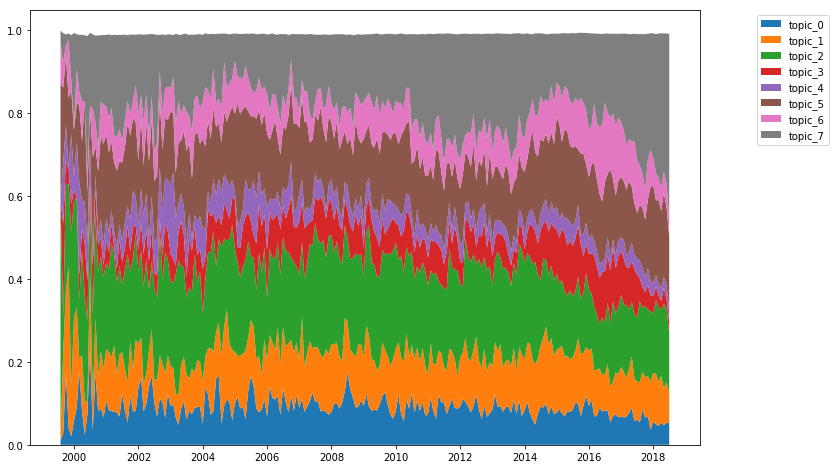

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.stackplot(a.index, a.T.values, labels=list(a.columns))
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

### Слова в топиках

In [21]:
ldamodel1.print_topics()

[(0,
  '0.011*"конкурс" + 0.010*"рекорд" + 0.009*"мир" + 0.006*"метр" + 0.005*"тысяча" + 0.005*"участие" + 0.005*"день" + 0.004*"книга" + 0.004*"мисс" + 0.004*"участник"'),
 (1,
  '0.007*"2017" + 0.005*"the" + 0.004*"ресторан" + 0.004*"заведение" + 0.004*"большой" + 0.004*"килограмм" + 0.003*"издание" + 0.003*"тысяча" + 0.003*"сеть" + 0.003*"житель"'),
 (2,
  '0.013*"тысяча" + 0.011*"доллар" + 0.008*"мужчина" + 0.006*"деньга" + 0.006*"дом" + 0.006*"миллион" + 0.005*"штат" + 0.005*"около" + 0.004*"рубль" + 0.004*"полицейский"'),
 (3,
  '0.010*"модель" + 0.009*"актриса" + 0.009*"опубликовать" + 0.008*"the" + 0.007*"миллион" + 0.007*"американский" + 0.007*"актёр" + 0.006*"журнал" + 0.005*"фото" + 0.005*"трамп"'),
 (4,
  '0.006*"остров" + 0.004*"кит" + 0.004*"уильямс" + 0.004*"россия" + 0.004*"российский" + 0.004*"власть" + 0.003*"австралия" + 0.003*"мир" + 0.003*"сша" + 0.003*"херд"'),
 (5,
  '0.015*"ребёнок" + 0.011*"женщина" + 0.008*"девушка" + 0.005*"семья" + 0.005*"издание" + 0.005*"м

### Топ слова.

In [22]:
word_counts = {}
for s in tqdm_notebook(doc_term_matrix):
    for w in s:
        if w[0] not in word_counts:
            word_counts[w[0]] = w[1]
        else:
            word_counts[w[0]] += w[1]

In [23]:
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

In [24]:
for w in sorted_word_counts[:50]:
    print(f'{dictionary[w[0]]} - {w[1]} times.')

тысяча - 8741 times.
the - 7558 times.
мужчина - 6642 times.
доллар - 6465 times.
женщина - 6302 times.
день - 6297 times.
ребёнок - 6081 times.
дом - 5740 times.
около - 5519 times.
штат - 5425 times.
житель - 5359 times.
издание - 5275 times.
животное - 5170 times.
писать - 4906 times.
сша - 4749 times.
место - 4704 times.
американский - 4624 times.
миллион - 4272 times.
daily - 4237 times.
местный - 4135 times.
решить - 4050 times.
большой - 4000 times.
сотрудник - 3982 times.
британский - 3946 times.
животный - 3863 times.
мир - 3809 times.
сделать - 3779 times.
произойти - 3732 times.
опубликовать - 3478 times.
девушка - 3284 times.
найти - 3250 times.
помощь - 3170 times.
из-за - 3126 times.
жизнь - 3077 times.
принять - 3036 times.
обнаружить - 3034 times.
инцидент - 2965 times.
семья - 2949 times.
новый - 2941 times.
сайт - 2897 times.
собака - 2848 times.
смочь - 2830 times.
удаться - 2791 times.
news - 2763 times.
конкурс - 2749 times.
случай - 2724 times.
друг - 2709 times.
